# Analysis of StormSurge at New Zealand

In this notebook, we will first preprocess the data of the tidal gauges, which envolves extracting some imortant information of the gauge of interest, and extracting also the principal components from the sea level pressure and its gradient in the area of interest. After that, we will:

- Estimate the best combination of parameters for the density probability function, adjusting the probability distribution to a GEV (with the parameters depending on the PCs)

- Predict the ss with the principal components of the SLP in the area choosed

In [1]:
# arrays
import sys
import random
import numpy as np
import pandas as pd
import xarray as xr

# plotting
from matplotlib import pyplot as plt
import plotly.graph_objects as go

# maths
from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# append sscode to path
import os 
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# data viewer
from sscode.data import load_era5
from sscode.pca import PCA_DynamicPred
from sscode.utils import spatial_gradient

# warnings
import warnings
warnings.filterwarnings('ignore')


 loading the sea-level-pressure fields... 


 loading daily resampled data... 



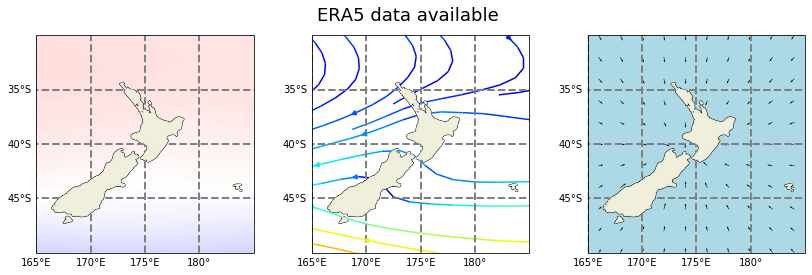

In [2]:
era5 = load_era5(time='1D')
slp, wind = era5[0], era5[1]

In [3]:
pcs_era5 = PCA_DynamicPred(slp,winds=(True,wind),region=(True,(170,175,-35,-40)))


 lets calculate the PCs... 


 adding the wind to the predictor... 


 winds predictor with shape: 
 (15341, 21, 21) 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (15341, 21, 21) 


 calculated PCs matrix with shape: 
 (15341, 2205) 



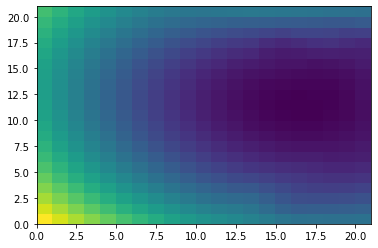

In [7]:
plt.pcolor(pcs_era5.EOFs.values[0,:][:21*21].reshape(21,21))

In [ ]:
sys.exit()

## Data preprocessing

### AVAILABLE TG

['Anawhata', 'Charleston', 'Dargaville', 'Dog_Is', 'Green_Is',
       'Jackson_bay', 'Kaikoura', 'Kaingaroa', 'Kapiti_Is', 'L_Kaiteriteri',
       'Marsden_Point', 'Mokohinau_Is', 'Moturiki_Is', 'Nelson', 'Sumner_Head',
       'Tarakohe', 'Tararu', 'Timaru', 'Whitianga_Wharf']

In [ ]:
station = 'Jackson_bay'

In [ ]:
data, PCs_data, ss_tg = data_loading(station=station, isite=5, num_pcs=4) 
# num_pcs is just for the calculation of the loglikelihood

In [ ]:
data.info(), PCs_data

## Linear Regression with PCA

In [ ]:
# prepare the linear predictor / predictand
num_pcs = np.where(np.cumsum(PCs_data.variance.values/\
                             np.sum(PCs_data.variance.values))>0.98)[0][0]
print('\n {} PCs and the tide will be used to predict!! \n'.format(num_pcs))
X_train = PCs_data.PCs[:,:num_pcs]
X_test = PCs_data.PCs[:,:num_pcs]
ss_train_codec = data.ss_CoDEC.values
ss_train_moana = data.ss_Moana.values
ss_test = ss_tg.ss.sel(time=np.intersect1d(
    data.index.values, ss_tg.time.values, return_indices=True)[0]
                      ).values

In [ ]:
# perform the linear regression
lm_codec = linear_model.LinearRegression()
lm_moana = linear_model.LinearRegression()
model_codec = lm_codec.fit(X_train, ss_train_codec)
model_moana = lm_moana.fit(X_train, ss_train_moana)
predictions_codec = model_codec.predict(X_test)
predictions_moana = model_moana.predict(X_test)

In [ ]:
# plot results
fig, axes = plt.subplots(ncols=2, figsize=(13,6))
axes[0].scatter(ss_test, predictions_codec, c='darkgreen')
axes[0].set_xlabel('Observations'), axes[0].set_ylabel('Predictions')
axes[0].plot([-1,1], [-1,1],c='red',lw=3)
axes[0].set_xlim(-0.3,0.5), axes[0].set_ylim(-0.3,0.5)
axes[0].set_title('CoDEC')
axes[1].scatter(ss_test, predictions_moana, c='darkblue')
axes[1].set_xlabel('Observations'), axes[0].set_ylabel('Predictions')
minss = min(min(ss_test), min(predictions_moana))
maxss = max(max(ss_test), max(predictions_moana))
axes[1].plot([-1,1], [-1,1],c='red',lw=3)
axes[1].set_xlim(-0.3,0.5), axes[1].set_ylim(-0.3,0.5)
axes[1].set_title('Moana')
fig.suptitle('SCATTER PLOTS!!',y=1.02,fontsize=20)
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(ss_test, c='black', alpha=0.7, label='Observations')
ax.plot(predictions_codec, c='darkgreen', alpha=0.7, label='Predictions CoDEC')
ax.plot(predictions_moana, c='darkblue', alpha=0.7, label='Predictions Moana')
plt.legend()
ax.set_xlabel('Time'), axes[1].set_ylabel('Predictions / Observations')
fig.suptitle('Visual comparison between predictions and real SS measures!! \n at {}'\
             .format(station.upper()),y=1.04,fontsize=20)

In [ ]:
print('Cuantitative comparison:')
print('R2 codec:') 
print(lm_codec.score(X_test,ss_test))
print('R2 moana:') 
print(lm_moana.score(X_test,ss_test))

In [ ]:
# zoom available
fig = go.Figure(layout=go.Layout(height=500, width=900,
                                 title='Visual comparison between TG and numerical models'))
fig.add_trace(go.Scatter(x=pd.to_datetime(ss_tg.time.values), y=ss_test,
                    mode='lines', name='TG measurements', opacity=0.7))
fig.add_trace(go.Scatter(x=pd.to_datetime(ss_tg.time.values), y=predictions_codec,
                    mode='lines', name='CoDEC predictions', opacity=0.7))
fig.add_trace(go.Scatter(x=pd.to_datetime(ss_tg.time.values), y=predictions_moana,
                    mode='lines', name='Moana predictions', opacity=0.7))
fig.show()

In [ ]:
sys.exit()

## Maximum likelihood parameters estimation

This is an example with each parameter depending on 2 PCs and a constant:
- bestx = [-0.03908617, 0.04326417, -0.01342341, 0.08552664, 0.00129292, 0.01053405, 0.03926688, -0.0235892, -0.02992359]

This is an example with epsilon constant:
- bestx = [-0.04302685, 0.1391113, 0.03944948, 0.02443369, 0.02891268, -0.01533266, 0.03045131]

In [ ]:
#---------------------------------------------------------------------------#
# PARAMETERS TO TUNE THE ALGORITHM
# Definition:
#   iseed  = the random seed number (for repetetive testing purpose;
#            pos integers)
#   iniflg = flag for initial parameter array (=1, included it in initial
#            population; otherwise, not included)
#   ngs =    number of complexes (sub-populations)
#   peps =   value of NORMALIZED GEOMETRIC RANGE needed for convergence
#   maxn =   maximum number of function evaluations allowed during 
#            optimization
#   kstop =  maximum number of evolution loops before convergency
#   pcento = the percentage change allowed in kstop loops before 
#            convergency
# Values:
iseed   = random.randint(0,10000)
iniflg  = 0
ngs     = 6
peps    = 0.01
maxn    = 3000
kstop   = 30
pcento  = 0.01
#------------------------------------------------------------------------#


# selection of the parameters for sceua
bl = np.ones(5) * -0.2
bu = np.ones(5) * +0.2
x0 = np.ones(5) * 0.01

# call the algorithm, that returns best likelihood and parameters
bestx, bestf, BESTX, BESTF, ICALL = sceua(x0,bl,bu,maxn,kstop,pcento,peps,
                                          ngs,iseed,iniflg,
                                          data=data)

In [ ]:
# return parameters, likelihood and AIC in this iteration
print('\n \n Parameters: ', bestx)
print('\n Likelihood: ', bestf)
print('\n')
# plot adjust
plot_parameters(BESTX, BESTF, ICALL)

In [ ]:
plot_adjust(bestx, data)